# Benchmark numerical schemes

```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016, 2017, 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import datetime
import sys
import pyopencl
import timeit

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
if (str.lower(sys.platform).startswith("linux")):
    os.environ["PYOPENCL_CTX"] = "0"
else:
    os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print("Using ", cl_ctx.devices[0].name)

Using  Tesla M2090


In [3]:
#Create output directory for images
imgdir='images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_2018_09_21-11_58_44


In [4]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

## Global test parameters

In [23]:
width = 512000
height = 512000

domain_sizes = [128, 256, 512, 1024]#, 2048, 4096]

#schemes = ["CTCS"] 
#schemes = ["FBL", "KP", "CDKLM"]
schemes = ["FBL", "CTCS", "KP", "CDKLM"]

#Timestep size    
dt = 8000/max(domain_sizes)
    
g = 9.81
r = 0.0

# Coriolis parameters: f + beta * y
f = 8.0e-5

timesteps = 5

end_time = (timesteps - 0.01)*dt
make_netCDF = False

print("Timesteps = " + str(end_time / dt))

Timesteps = 4.99


## Numerical schemes

In [6]:
def runFBL():
    ghosts = [0,0,0,0] # north, east, south, west
    dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                 sim_args["nx"] + ghosts[1]+ghosts[3])

    h0 = np.ones(dataShape, dtype=np.float32) * 60
    eta0 = np.zeros(dataShape, dtype=np.float32)
    u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32)
    v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32)

    #Create bump in to lower left of domain for testing
    addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

    #Initialize simulator
    fbl_args = {"H": h0, "eta0": eta0, "hu0": u0, "hv0": v0}
    sim = FBL.FBL(**fbl_args, **sim_args)

    #Run
    t = sim.step(end_time)
    
    sim.cleanUp()

In [7]:
def runCTCS():
    ghosts = [1,1,1,1] # north, east, south, west
    dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                 sim_args["nx"] + ghosts[1]+ghosts[3])

    h0 = np.ones(dataShape, dtype=np.float32) * 60.0;
    eta0 = np.zeros(dataShape, dtype=np.float32);
    u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
    v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);       

    #Create bump in to lower left of domain for testing
    addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

    #Initialize simulator
    ctcs_args = {"H": h0, "eta0": eta0, "hu0": u0, "hv0": v0, "A": 1.0}
    sim = CTCS.CTCS(**ctcs_args, **sim_args)

    #Run
    t = sim.step(end_time)
    
    sim.cleanUp()

In [8]:
def runKP():
    ghosts = np.array([2,2,2,2]) # north, east, south, west
    dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                 sim_args["nx"] + ghosts[1]+ghosts[3])

    Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
    eta0 = np.zeros(dataShape, dtype=np.float32)
    u0 = np.zeros(dataShape, dtype=np.float32)
    v0 = np.zeros(dataShape, dtype=np.float32)

    #Create bump in to lower left of domain for testing
    addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

    #Initialize simulator
    ctcs_args = {"Hi": Hi, "eta0": eta0, "hu0": u0, "hv0": v0, "use_rk2": True}
    sim = KP07.KP07(**ctcs_args, **sim_args)

    #Run
    t = sim.step(end_time)
    
    sim.cleanUp()

In [9]:
def runCDKLM():
    ghosts = np.array([2,2,2,2]) # north, east, south, west
    dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                 sim_args["nx"] + ghosts[1]+ghosts[3])

    Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
    eta0 = np.zeros(dataShape, dtype=np.float32)
    u0 = np.zeros(dataShape, dtype=np.float32)
    v0 = np.zeros(dataShape, dtype=np.float32)

    #Create bump in to lower left of domain for testing
    addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

    #Initialize simulator
    ctcs_args = {"Hi": Hi, "eta0": eta0, "hu0": u0, "hv0": v0, "rk_order": 2}
    sim = CDKLM16.CDKLM16(**ctcs_args, **sim_args)

    #Run
    t = sim.step(end_time)
    
    sim.cleanUp()

## Control

In [22]:
sim_args = {
"cl_ctx": cl_ctx,
"nx": domain_sizes[0], "ny": domain_sizes[0],
"dx": float(width/domain_sizes[0]), "dy": float(width/domain_sizes[0]),
"dt": dt,
"g": g,
"f": f,
"r": r
}

out_filename = imgdir + "/profiling_data.npz"
data = {}

for scheme in schemes:
    print("Scheme: " + scheme)
    
    elapsed_per_size = np.empty(len(domain_sizes))

    # Run scheme for all defined domain sizes
    for i, domain_size in enumerate(domain_sizes):
        sim_args["nx"] = domain_size
        sim_args["ny"] = domain_size
    
        sim_args["dx"] = float(width/domain_size)
        sim_args["dy"] = float(height/domain_size)
    
        print("\tDomain size: " + str(domain_size))
        
        start_time = timeit.default_timer()
        eval("run" + scheme + "()")
        elapsed = timeit.default_timer() - start_time
        
        print("\t\t" + str(elapsed))
        elapsed_per_size[i] = elapsed
        
    data[str(scheme)] = elapsed_per_size

np.savez(out_filename, **data)


Scheme: CTCS
	Domain size: 128


RuntimeError: clEnqueueNDRangeKernel failed: OUT_OF_RESOURCES

## Plot

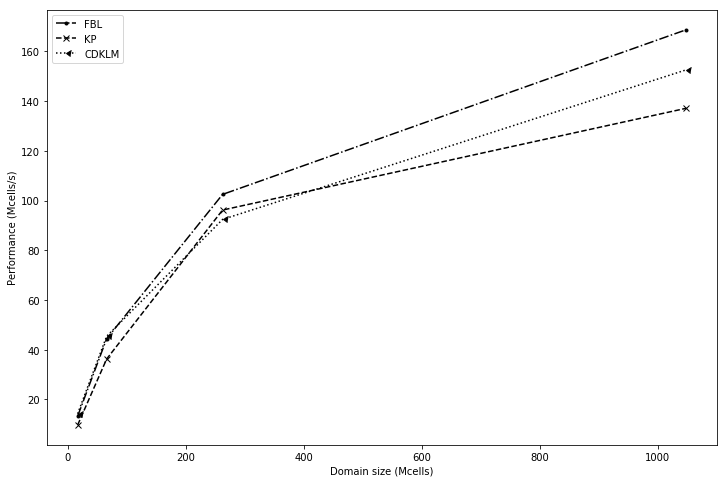

In [20]:
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())

in_filename = imgdir + "/profiling_data.npz"

with np.load(in_filename) as npzfile:
    for scheme in schemes:
        plt.plot(np.array(domain_sizes)**2*0.001, (np.array(domain_sizes)**2/npzfile[str(scheme)].astype(np.float64))*0.001)

plt.xlabel('Domain size (Mcells)')
plt.ylabel('Performance (Mcells/s)')

plt.legend(schemes)

## TODO

  * Fix CTCS bug (on second run, every time): RuntimeError: clEnqueueNDRangeKernel failed: OUT_OF_RESOURCES
  * Verify simulation results
  * Notebook -> script
  * Run on desktop, MET HPC and Abel (anything forgotten?)
  * Make system comparison plot (bar plot?)
  * Port to comparable CUDA revision (revision ???), repeat runs